# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# simulation output folder
experiment_name = 'explore_demand_3'

# load Java simulation data
experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
# experiment_folder = fr'data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Progress of fundamental diagram variables: Flow and Density

Selected variables are chosen and their progress is plotted. It is likely that the values of a variable will approach a stable value. This stabalization will indicate that the simulation has achieved a stable state.

In [5]:
# selected warm-up time
# warm_up_time = None
warm_up_time = 500

In [6]:
def show_fd_data_progress(df, warm_up_time_value):
    # create plots for all variables
    n_columns = 4
    n_rows = (len(df.columns) + 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(24, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable/column
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run' and 'seed' combination
        run_seed_grouped = df.groupby(['run', 'seed'])
    
        # plot each run-seed combination
        for (run, seed), run_seed_group in run_seed_grouped:
            # plot line
            run_seed_group.reset_index()
            line, = axes[i].plot(run_seed_group['time'], run_seed_group[column], label=f'Seed{seed}, run{run}', alpha=0.5)
            line_color = line.get_color()
    
        # plot selected warm-up time
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', label='Warm-up time')
            
        # set plot titles and labels
        units = '-'
        if 'speed' in column:
            units = 'm/s'
        elif 'flow' in column:
            units = 'vehicle/s'
        elif 'density' in column:
            units = 'vehicle/m'
            
        axes[i].set_title(f'{column.replace("_", " ")} progression over time')
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(f'{column.split("_")[1].capitalize()} [{units}]')
        axes[i].grid(True)
    
        # extend only the right (x_max) and top (y_max) by 10%
        x_min, x_max = axes[i].get_xlim()
        y_min, y_max = axes[i].get_ylim()
        axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
        
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show plots
    plt.tight_layout()
    plt.show()


def show_fd_data_progress_ma(df, warm_up_time_value, window_size):
    # create plots for all variables
    n_columns = 4
    n_rows = (len(df.columns) + 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(24, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable/column
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run' and 'seed' combination
        run_seed_grouped = df.groupby(['run', 'seed'])
    
        # plot each run-seed combination with moving average
        for (run, seed), run_seed_group in run_seed_grouped:
            # Sort by time to ensure correct rolling calculation
            run_seed_group = run_seed_group.sort_values(by='time')

            # Calculate moving average for the selected column
            run_seed_group[f'{column}_moving_avg'] = run_seed_group[column].rolling(window=window_size, min_periods=1).mean()
            
            # Plot moving average
            line, = axes[i].plot(run_seed_group['time'], run_seed_group[f'{column}_moving_avg'], 
                                 label=f'Seed {seed}, Run {run} (MA)', alpha=0.7)
    
        # plot warm-up time if specified
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')
            
        # Set plot titles and labels
        units = '-'
        if 'speed' in column:
            units = 'm/s'
        elif 'flow' in column:
            units = 'vehicle/s'
        elif 'density' in column:
            units = 'vehicle/m'
            
        axes[i].set_title(f'{column.replace("_", " ")} moving average progression over time')
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(f'{column.split("_")[1].capitalize()} [{units}]')
        axes[i].grid(True)
    
        # Extend only the right (x_max) and top (y_max) by 10%
        x_min, x_max = axes[i].get_xlim()
        y_min, y_max = axes[i].get_ylim()
        axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
        
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show plots
    plt.tight_layout()
    plt.show()

In [7]:
# get intermediate FD values
variables = ['AB.LEFT_speed', 'AB.LEFT_density', 'AB.LEFT_flow',
             'AB.RIGHT_speed', 'AB.RIGHT_density', 'AB.RIGHT_flow',
             'CD.LEFT_speed', 'CD.LEFT_density', 'CD.LEFT_flow',
             'CD.RIGHT_speed', 'CD.RIGHT_density', 'CD.RIGHT_flow',
             'E2B.ONRAMP_speed', 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow']
df_fd = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd = df_fd.dropna(subset=['AB.RIGHT_flow'])
# add time column
df_fd['time'] = df_fd.groupby(['seed', 'run']).cumcount() * 30
variables_of_interest = ['time', 'seed', 'run'] + variables
columns_to_include = [col for col in df_fd.columns if col in variables_of_interest]
df_fd = df_fd[columns_to_include]

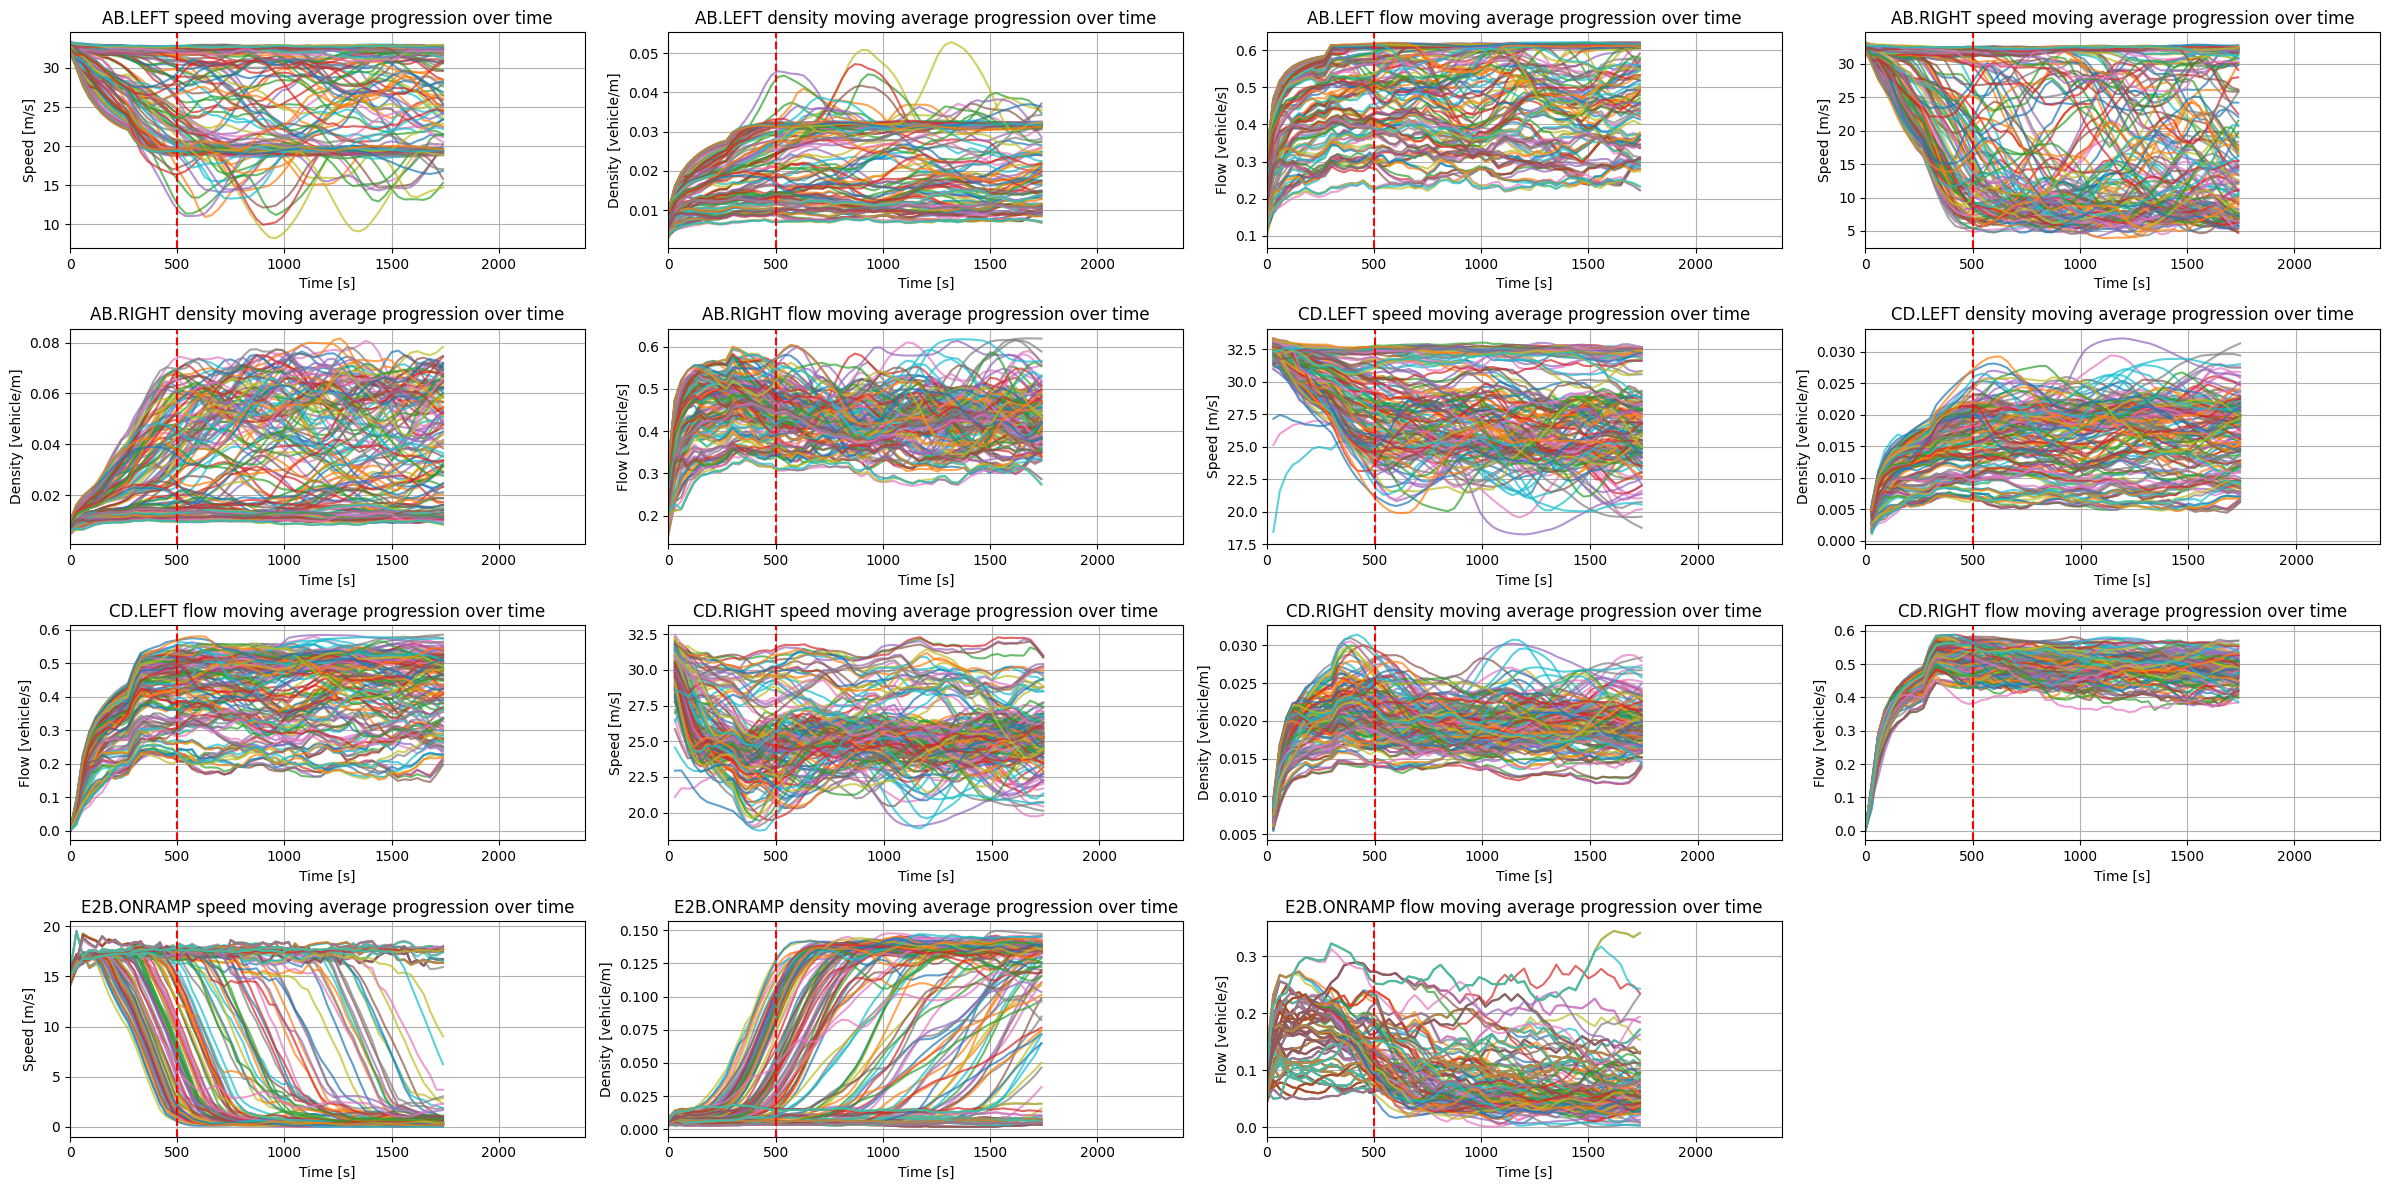

In [8]:
show_fd_data_progress_ma(df_fd, warm_up_time, 10)

Flow and density values for specific lanes within the road network show a development throughout the whole simulation run. While some runs tend to become stable, others have much variation or become stable later. If a warm-up time of 1000 - 1500 seconds is selected, this means that the dynamics of this development are not taken into account. However, we are interested in this development throughout the simulation. The warm-up time is only implemented to leave out the starting phase of the simlation where the road network is still filling up with vehicles.

### 2. Progress of vehicles in the road network

In [9]:
def plot_vehicles_in_network(df, warm_up_time_value):
    # count the number of vehicles for each time step, run, and seed
    vehicle_count = df.groupby(['time', 'run', 'seed'])['gtu_id'].nunique().reset_index()
    
    # rename the column to something more descriptive
    vehicle_count.rename(columns={'gtu_id': 'vehicle_count'}, inplace=True)

    # plot the vehicle count over time for each seed and run combination
    fig, ax = plt.subplots(figsize=(12, 6))

    # group by 'run' and 'seed' to plot each combination separately
    run_seed_grouped = vehicle_count.groupby(['run', 'seed'])
    
    # plot each run-seed combination
    for (run, seed), run_seed_group in run_seed_grouped:
        ax.plot(run_seed_group['time'], run_seed_group['vehicle_count'], label=f'Seed {seed}, Run {run}', alpha=0.7)

    # plot warm-up time if specified
    if warm_up_time_value is not None:
        ax.axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')

    # set plot titles and labels
    ax.set_title('Vehicle Count Progression Over Time for Each Run and Seed')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Vehicle count')
    ax.grid(True)
    
    # show the plot
    plt.tight_layout()
    plt.show()

In [10]:
variables = ['time', 'gtu_id']
df_gtu = load_dataframe(variables, experiment_folder, sequence_output, input_values)

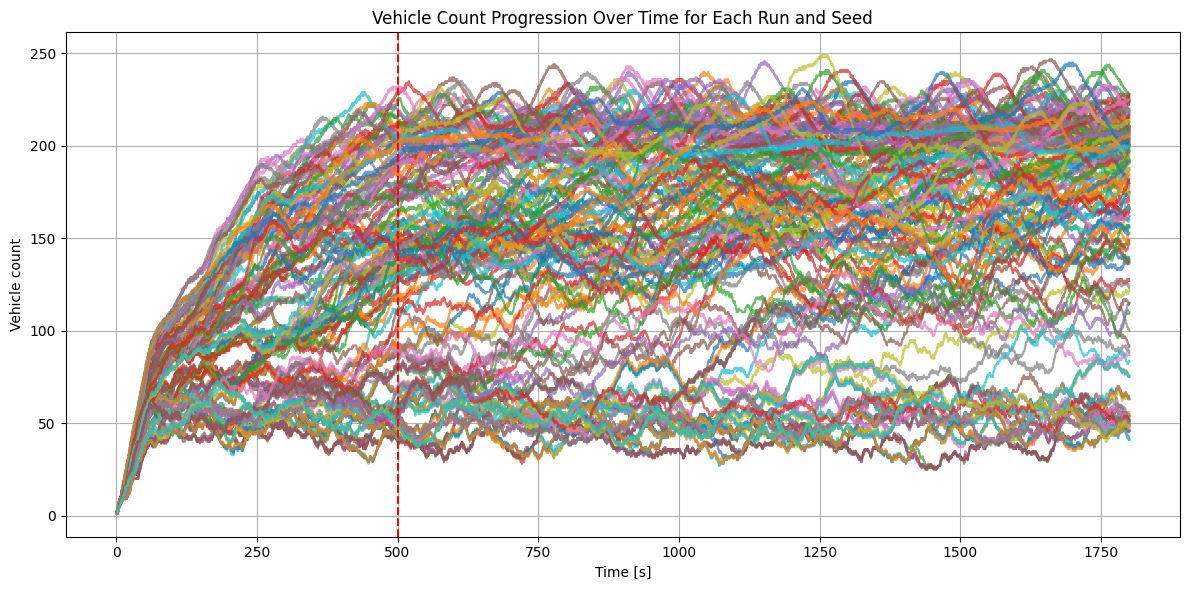

In [11]:
plot_vehicles_in_network(df_gtu, warm_up_time)

### 3. Progress of GTU variables

In [12]:
def show_gtu_data_progress(df, warm_up_time_value):
    # Sort the data by seed and run to ensure consistent ordering
    df = df.sort_values(by=['seed', 'run', 'time'])

    # Create plots for all variables of interest
    n_columns = 3
    n_rows = len(df.columns.drop(['time', 'seed', 'run']))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable of interest (excluding 'time', 'seed', 'run')
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run' and 'seed' and calculate the mean for each time step within each group
        run_seed_grouped = df.groupby(['run', 'seed', 'time']).agg({column: 'mean'}).reset_index()
    
        # Plot the mean progression for each (run, seed) combination
        for (run, seed), run_seed_group in run_seed_grouped.groupby(['run', 'seed']):
            # Plot the mean value for each time step
            axes[i].plot(run_seed_group['time'], run_seed_group[column], label=f'Seed {seed}, Run {run}', alpha=0.5)
    
        # Plot warm-up time if specified
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')
    
        # Set plot titles, labels, and other formatting
        units = 'm/s' if 'speed' in column else 'm/s²' if 'acceleration' in column else 's'
        axes[i].set_title(f'Mean {column.capitalize().replace("_", " ")} progression over time')
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(f'{column} [{units}]')
        axes[i].grid(True)
    
    # Hide any unused subplots if fewer variables than subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show the plots with a tight layout
    plt.tight_layout()
    plt.show()

# because of many fluctuations, a moving average is applied to see the underlying trend
def show_gtu_data_progress_ma(df, warm_up_time_value, window_size=5):
    # Sort the data by seed, run, and time to ensure consistent ordering
    df = df.sort_values(by=['seed', 'run', 'time'])

    # Create plots for all variables of interest
    n_columns = 3
    n_rows = len(df.columns.drop(['time', 'seed', 'run']))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, n_rows * 3))
    axes = axes.flatten()
    
    # Loop through each variable of interest (excluding 'time', 'seed', 'run')
    for i, column in enumerate(df.columns.drop(['time', 'seed', 'run'])):
        # Group by 'run', 'seed' and 'time' and calculate the mean for each time step within each group
        run_seed_grouped = df.groupby(['run', 'seed', 'time']).agg({column: 'mean'}).reset_index()
    
        # Plot the moving average progression for each (run, seed) combination
        for (run, seed), run_seed_group in run_seed_grouped.groupby(['run', 'seed']):
            # Sort by time for rolling calculation
            run_seed_group = run_seed_group.sort_values(by='time')

            # Calculate moving average for the selected column
            run_seed_group[f'{column}_moving_avg'] = run_seed_group[column].rolling(window=window_size, min_periods=1).mean()
            
            # Plot the moving average progression over time
            axes[i].plot(run_seed_group['time'], run_seed_group[f'{column}_moving_avg'], label=f'Seed {seed}, Run {run} (MA)', alpha=0.7)
    
        # Plot warm-up time if specified
        if warm_up_time_value is not None:
            axes[i].axvline(x=warm_up_time_value, color='red', linestyle='--', label='Warm-up time')
    
        # Set plot titles, labels, and other formatting
        units = 'm/s' if 'speed' in column else 'm/s²' if 'acceleration' in column else 's'
        axes[i].set_title(f'Moving Average of {column.capitalize().replace("_", " ")} Progression Over Time')
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(f'{column} [{units}]')
        axes[i].grid(True)
    
    # Hide any unused subplots if fewer variables than subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show the plots with a tight layout
    plt.tight_layout()
    plt.show()

In [13]:
# Define variables and load data
variables = ['time', 'acceleration', 'speed', 'desired_speed', 'headway_time', 'desired_headway_time', 'headway_distance']
df_sequence = load_dataframe(variables, experiment_folder, sequence_output, input_values)
variables_of_interest = ['seed', 'run'] + variables
columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
df_filtered = df_sequence[columns_to_include]

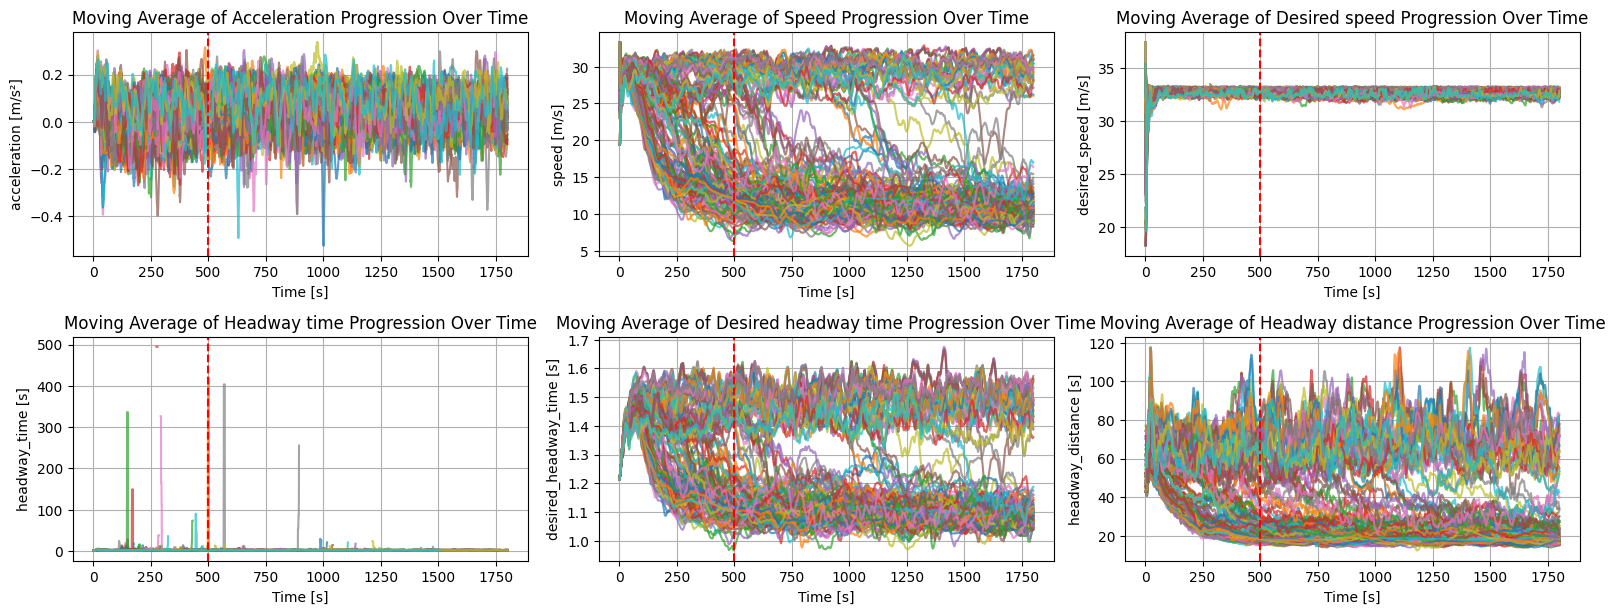

In [14]:
show_gtu_data_progress_ma(df_filtered, warm_up_time, 10)

### 4. Conclusions
Graphs of variable progress through simulation runs already showed that a warm-up time is required. In the first x seconds of the simulation, vehicles are filling up the freeway network and variables have a high variability during this period. While this variability remains high for the fundamental diagram variables (mean speed, mean flow and mean density), the individual GTU variables (acceleration, speed, desired headway etc.) do show stabilization after a while. A statistical significance test is performed on these variables to determine the duration of the warm-up time required to reach the stable state of the simulation. The result is a warm-up time of <b>500</b> seconds.

When this warm-up time is plotted into the variable progress graphs, the visuals clearly show that the post-warm-up duration of the simulation shows less variability than in the pre-warm-up duration.